# Optimizing Market Campaigns: Predicting Term Deposit Subscriptions.

## Problem Statement

Although the bank's marketing staff is spending a lot of money phoning customers, term deposit subscription conversion rates are still poor.  To more effectively target potential subscribers, lower campaign expenses, and boost overall marketing effectiveness, it is necessary to determine which client attributes are most linked to a favourable response.

## Business Questions

**1. Which customer and campaign features most strongly influence the likelihood of subscription?**
- Important client segments can be created by determining important characteristics like age, marital status, education, and type of work.  This makes it possible to create more intelligent campaigns, decrease outreach to consumers who aren't interested, and boost conversion rates. 

**2. How can we use model predictions to prioritize clients and reduce unnecessary marketing efforts?**
- We can more effectively distribute resources (e.g. call centre prioritisation) by ranking consumers by probability rather than just predicting who is likely to subscribe.  This results in a marketing plan that is more flexible and economical.

**3. Can we accurately predict which customers are likely to subscribe to a term deposit based on their profile?**
- Campaign scheduling, agent scripts, and client preparedness can all be enhanced by knowing trends in the month, previous¬†outcome (poutcome), and call duration.

## Data Cleaning

In [111]:
#importing vital libraries needed for the project
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
plt.style.use('seaborn-v0_8-darkgrid')

Next we load and inspect the dataset.

In [112]:
df = pd.read_csv('bank-full.csv',delimiter=';') #';' seperated so we use a delimiter
df # print the first five rows

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
0        unknown    5   may       261         1     -1         0  unknown   no  
1        unknown    5   may       151         1     -1         0  unknown   no  
2        unknown    5   may        76         1     -1         0  unknown   no  
3        unknown    5   may        92         1     -1         0  unknown   no  
4        unknown    5   may       198         1     -1         0  unknown   no  
...          ...  ...   ...       ...       ...    ...       ...      ...  ...  
45206   cellular   17   nov       977         3     -1         0  unknown  yes  
45207   cellular   17   nov       456         2     -1         0  unknown  yes  
45208   cellular   17   nov      1127         5    184         3  success  yes  
45209  telephone   17   nov       508         4     -1         0  unknown   no  
45210   cellular   17   nov       361         2    188        11    other   no  

[45211 rows x 17 columns]

In [113]:
df.info() #To check the data types and if we have any missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


We have 7 numerical feactures and 10 objects(categorical/strings).

In [114]:
df.describe #to check for unknowns and NaNs in the dataset overally

<bound method NDFrame.describe of        age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact 

In [115]:
df['poutcome'].isnull().describe() #our target variable(subscribed or not)

count     45211
unique        1
top       False
freq      45211
Name: poutcome, dtype: object

In [116]:
df['poutcome'].value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [117]:
df['job'].value_counts()#check for any unknowns

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

In [118]:
from sklearn.impute import SimpleImputer # import imputer to convert the 'unknowns','nulls'
df[['job']] = df[['job']].replace('unknown', np.nan)#replace 'unknown' with nan for the imputer to work
imputer = SimpleImputer(strategy='most_frequent') #replacing the NaNs with the most frequent value
df[['job']] = imputer.fit_transform(df[['job']])#passing all the columns to impute all at once


In [119]:
df['job'].value_counts()

job
blue-collar      10020
management        9458
technician        7597
admin.            5171
services          4154
retired           2264
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
Name: count, dtype: int64

In [120]:
df[['education']] = df[['education']].replace('unknown', np.nan)

imputer = SimpleImputer(strategy='most_frequent') #replacing the NaNs with the most frequent value
df[['education']] = imputer.fit_transform(df[['education']])

In [121]:
df['loan'].unique()#to be encoded 

array(['no', 'yes'], dtype=object)

In [122]:
df['age'].unique() #have no nans or unknowns , scale for logistic regression

array([58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57, 51, 45, 60, 56, 32,
       25, 40, 39, 52, 46, 36, 49, 59, 37, 50, 54, 55, 48, 24, 38, 31, 30,
       27, 34, 23, 26, 61, 22, 21, 20, 66, 62, 83, 75, 67, 70, 65, 68, 64,
       69, 72, 71, 19, 76, 85, 63, 90, 82, 73, 74, 78, 80, 94, 79, 77, 86,
       95, 81, 18, 89, 84, 87, 92, 93, 88], dtype=int64)

In [123]:
df['previous'].unique()

array([  0,   3,   1,   4,   2,  11,  16,   6,   5,  10,  12,   7,  18,
         9,  21,   8,  14,  15,  26,  37,  13,  25,  20,  27,  17,  23,
        38,  29,  24,  51, 275,  22,  19,  30,  58,  28,  32,  40,  55,
        35,  41], dtype=int64)

In [124]:
df['date'] = pd.to_datetime(df['day'].astype(str) + '-' + df['month'] + '-2025', format='%d-%b-%Y')#convert the day to date and month, add a dummy year
df['day_of_week'] = df['date'].dt.day_name() #extract day of week(name)
df.drop('date',axis=1, inplace=True)#drop the dummy date column
df['day_of_week'].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [125]:
#pdays is number of days since contacted but has -1 as no previous contact
df['was_previously_contacted'] = df['pdays'].apply(lambda x: 0 if x == -1 else 1) #create a new column, contacted or not
df['days_since_contact'] = df['pdays'].apply(lambda x: x if x != -1 else 0) #new column and convert the -1 to 0


df = df.drop('pdays', axis=1)

In [126]:
df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married  secondary      no     1506     yes   no   
4   33   blue-collar   single  secondary      no        1      no   no   

   contact  day month  duration  campaign  previous poutcome   y day_of_week  \
0  unknown    5   may       261         1         0  unknown  no      Monday   
1  unknown    5   may       151         1         0  unknown  no      Monday   
2  unknown    5   may        76         1         0  unknown  no      Monday   
3  unknown    5   may        92         1         0  unknown  no      Monday   
4  unknown    5   may       198         1         0  unknown  no      Monday   

   was_previously_contacted  days_since_contact  
0                         0                   0  
1                         0                   0  
2                         0                   0  
3                         0                   0  
4                         0                   0

In [127]:
df['previous'].unique()

array([  0,   3,   1,   4,   2,  11,  16,   6,   5,  10,  12,   7,  18,
         9,  21,   8,  14,  15,  26,  37,  13,  25,  20,  27,  17,  23,
        38,  29,  24,  51, 275,  22,  19,  30,  58,  28,  32,  40,  55,
        35,  41], dtype=int64)

## Exploratory Data Analysis

In [128]:
#analyze imblance in the predicted variable
df['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

Has a huge class imbalance between the subscribers and non-subscribers.  
To visually inspect the distribution 

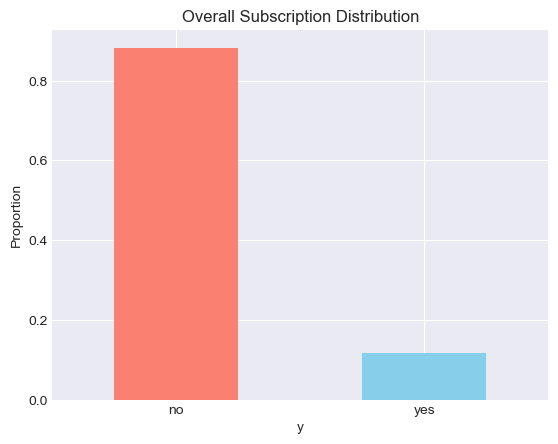

In [129]:
df['y'].value_counts(normalize=True).plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Overall Subscription Distribution')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()


- From the graph, there's about 88% chance of people not subscribing and about 12% chance rate of clients subscribing. 
 
- We'll visualize a few features and see the different subscription rates.

**Job Distribution by Subscribers**

Helps the marketing department to be able to narrow down which job groups they ought to pay more attention to during the campaign.

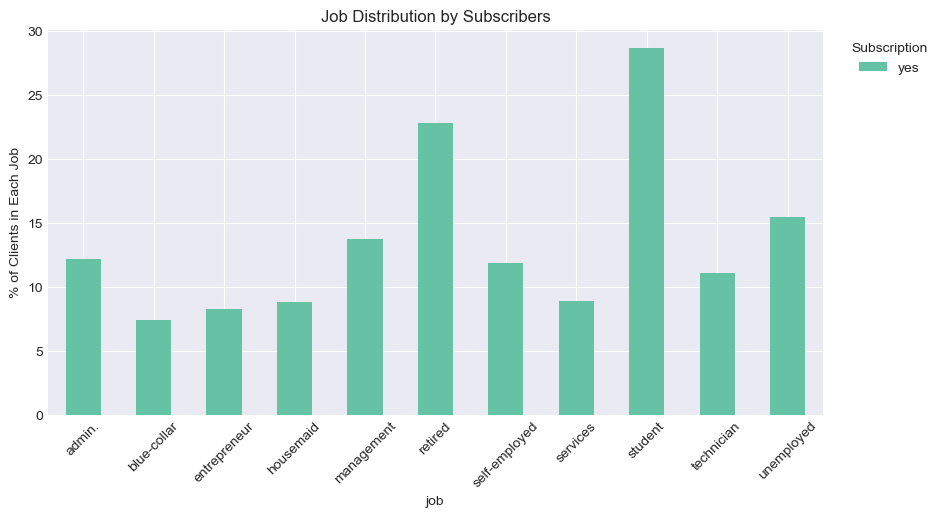

In [130]:
#comapare subscriber vs non-subscriber distribution
subscriber_df = df[df['y'] == 'yes']
nonsubscriber_df = df[df['y'] == 'no']
#to compare job distribution subscrition rate
job_counts = pd.crosstab(df['job'], df['y'], normalize='index') * 100
job_counts['yes'].plot(kind='bar', stacked=True,figsize=(10,5), colormap='Set2')
plt.title('Job Distribution by Subscribers')
plt.ylabel('% of Clients in Each Job')
plt.xticks(rotation=45)
plt.legend(title='Subscription', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

- From the graph we can see that Students have a higher rate of  subscribing followed by the retired, unemployed and management job groups.   
- On the other hand, blue-collar jobs , entreprenuers , housemaids and services jobs have the highest rates of not subscribing.  

- The marketing department may focus more on students, retirees, unemployed and management than the other job groups.

**Education Level by Subscription Status**

This helps in reducing the clients that are likely to subscribe to the deposits based on their level of eduaction.

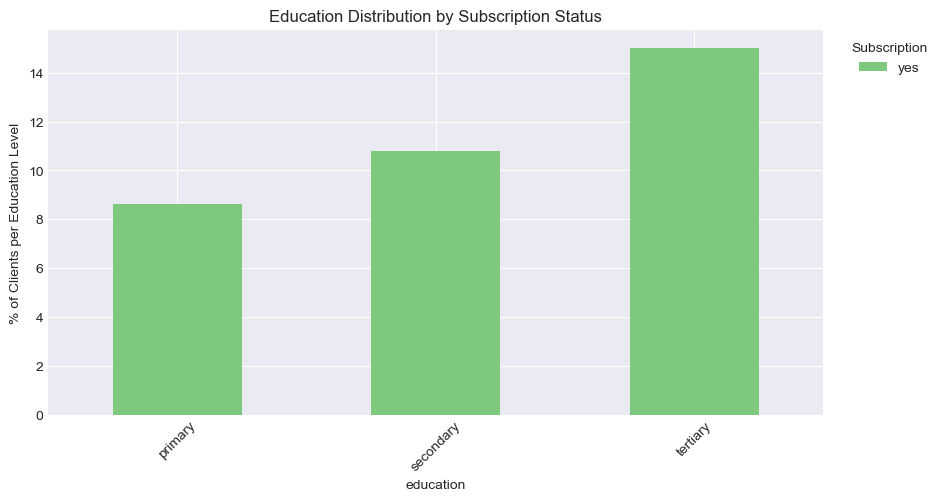

In [131]:
education_counts = pd.crosstab(df['education'], df['y'], normalize='index') * 100
education_counts['yes'].plot(kind='bar', stacked=True,figsize=(10,5), colormap='Accent')
plt.title('Education Distribution by Subscription Status')
plt.ylabel('% of Clients per Education Level')
plt.xticks(rotation=45)
plt.legend(title='Subscription', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

- The graph shows that tertiary has the highest rate of subscription of the education level .
- Primary education level having the lowest subscription rate followed by Secondary School level.
- The main focus of the marketing calls should target tertiary level education.

**Subscriber rate by Month**

Helps the department to know which months are suitable to conduct the campaigns saving on time wasted and to save energy with zero returns.

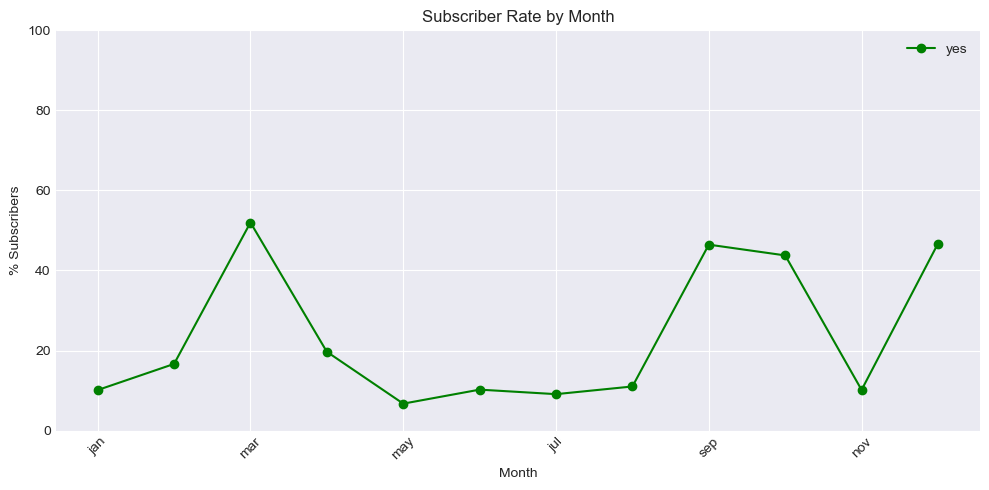

In [132]:
#distribution of subscribers by month
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
#convert month column to categorical in the above order
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

month_dist = pd.crosstab(df['month'], df['y'], normalize='index') * 100 #converts the counts to percentage
month_dist['yes'].plot(kind='line', figsize=(10,5), color='green', marker='o')#marks the months with painted dots
plt.title('Subscriber Rate by Month')
plt.ylabel('% Subscribers')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


- From the graph, March, September, October and December record the highest percenatge of subscriptions.  

- While the least number of subscriptions are recorded during January, and from May to August, then shifting to November.  

- The grapgh indicates the months that the marketing team ought to target calling the customers avoiding the months with least   subscribers.

**Subscription rate by Day of Week**

This will help indicate the days of the week that has the highest records of subscriptions thus reducing the
  
cost of making calls throughout the week.

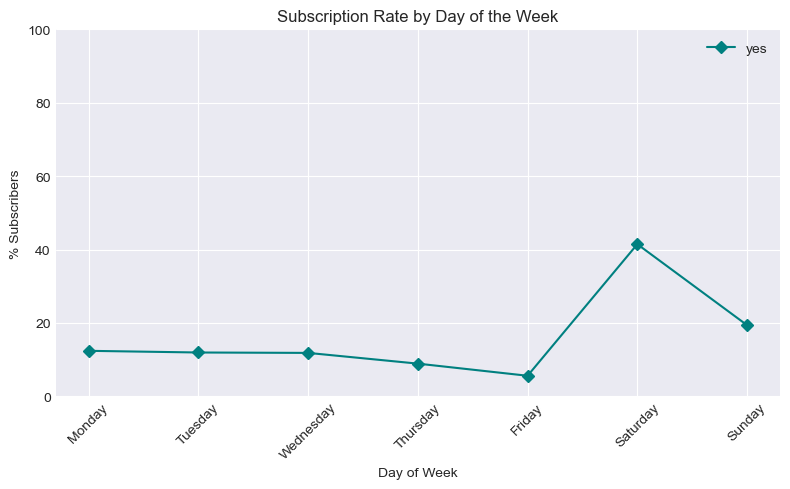

In [133]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] #correct order for weekdays
# Convert the 'day_of_week' column to a categorical type with the defined order
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

day_dist = pd.crosstab(df['day_of_week'], df['y'], normalize='index') * 100 #normalize to get percentage of 'yes' per day
day_dist['yes'].plot(kind='line', color='teal', marker='D', figsize=(8, 5)) #Plot the percentage of subscribers

plt.title('Subscription Rate by Day of the Week')
plt.ylabel('% Subscribers')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


- From the graph , the rate of subscription is constant throughout the week till a dip on Friday. 
   
- The rate spikes up on Saturdays and decreases abit on Sunnday.  

- The graph indicates that calls ought to made more during weekends as it has the highest rate of subscriptions.

In [134]:
#create a copy to carry out a one-way ANOVA test and also a Chi-squatre test
df_copy = df.copy()

In [135]:
#import libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
#start by carrying out ANOVA test
df_copy['y'] = df_copy['y'].map({'no': 0, 'yes': 1})# change to numeric (0/1)

#conduct the test on job and eduacation features/ categories
model_job = ols('y ~ C(job)', data=df_copy).fit() #job
anova_job = sm.stats.anova_lm(model_job, typ=2)

model_edu = ols('y ~ C(education)', data=df_copy).fit()#education
anova_edu = sm.stats.anova_lm(model_edu, typ=2)

print("ANOVA for job:\n", anova_job)
print("\nANOVA for education:\n", anova_edu)

ANOVA for job:
                sum_sq       df          F         PR(>F)
C(job)      85.794998     10.0  84.588446  1.297541e-173
Residual  4584.472370  45200.0        NaN            NaN

ANOVA for education:
                    sum_sq       df           F        PR(>F)
C(education)    23.121994      2.0  112.466796  1.894092e-49
Residual      4647.145375  45208.0         NaN           NaN


- **job** - - has a f(p-value ) of 1.297541e-173 which is approaching 0.0 and less than 0.05. This indicates that job categories  
  
  affect the subscription rate. Job type affects the likelihood of subscribing to the term deposit campaign.  

- The F-statistic is also quite high, further supporting the strong difference between job groups



- **Education** - - the p-value is near zero (1.197579e-51), indicating significant differences in subscription rates across education 

   levels.

- This indicates that Education level is also significantly associated with the likelihood of subscription.

- The F-statistic is also quite high, further supporting the strong difference between Education level.


In [136]:
#run a chi_square for inference
from scipy.stats import chi2_contingency
#checking for previous outcomes and target variable
contingency = pd.crosstab(df_copy['poutcome'], df_copy['y'])#contingency table
chi2, p, dof, expected = chi2_contingency(contingency)#chi-square test

print("Chi-square statistic:", chi2)#print the ochi-square, degrees of freedom(k-1), and p-value
print("Degrees of freedom:", dof)
print("p-value:", p)

Chi-square statistic: 4391.5065887686615
Degrees of freedom: 3
p-value: 0.0


- **Chi-square statistic: 4391.5065887686615** -- this big Chi-Square value indicates that there's a huge difference between the 
 observed and expected values in the 'poutcome' √ó 'y' table.  

- **p-value: 0.0** -- less than (0.05). This means that there is an extremely strong, statistically significant association between  
 'poutcome' and 'y'.

- The outcome of the previous campaign (poutcome) has a major influence on whether a customer subscribes to the term deposit (y).

In [137]:
#come up with a correlation matrix to show the relationship between the continuous variables in the dataset to the target
correlation_matrix = df_copy[['age', 'campaign', 'y']].corr()
#print out the matrix
print(correlation_matrix)

               age  campaign         y
age       1.000000  0.004760  0.025155
campaign  0.004760  1.000000 -0.073172
y         0.025155 -0.073172  1.000000


- **age vs y = 0.025** - - Signifies a very weak positive correlation. Meaning age has almost no linear relationship with subscription.
   Though non-linear relationships might still exist.

- **campaign vs y = -0.073** - - Indicates that there is a very weak negative correlation; Slightly suggests that more contacts 
    may reduce the chance of subscription.Though could still be important in non-linear models (trees), but linear effect is weak.  

- **age vs campaign = 0.0047** - - The output is very small; indicating that there's no meaningful relationship between a person‚Äôs  
    age and how many times they were contacted.

## 1. Which customer and campaign features most strongly influence the likelihood of subscription?

- Here, we'll use probability scores to create a ranked list of prospects, not just (yes/no).

**Group the data to predicted and predictor**

In [138]:
#grouping the data into predicted and predictors for splitting
y = df['y']
x = df.drop(columns=['y', 'contact'], axis=1)

We split the data next.

There is an imbalance between the non-subscribers and subscribers. We'll use SMOTE to balance the outcome.  
But we start by splitting the data to prevent leakage into the model.

In [139]:
#train test_split the data first to avoid data leakeage to our model
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [140]:
#scaling continuous features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_scale =['age','balance','duration','campaign','day','days_since_contact']
new_scale_names = [col + '_scaled' for col in columns_scale]
#fit and transform the train dataset
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train[columns_scale]),columns=new_scale_names, index=x_train.index)
#only transform the test dataset
x_test_scaled = pd.DataFrame(scaler.transform(x_test[columns_scale]),columns=new_scale_names, index=x_test.index)


In [141]:
#import labelencoder.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_cols = ['loan', 'default', 'housing']
label_cols_names = [col + '_lencoded' for col in label_cols]
#fit and transform train data (initiate the dataframes first)
x_train_lencoded = pd.DataFrame(index=x_train.index)
#transform the test data (initiate the dataframes first)
x_test_lencoded = pd.DataFrame(index=x_test.index)
#Apply encoder per column 

for col, new_col in zip(label_cols, label_cols_names):
    le = LabelEncoder()
    x_train_lencoded[new_col] = le.fit_transform(x_train[col])
    x_test_lencoded[new_col] = le.transform(x_test[col])
#fit and transform the target train and transform test only
target_le = LabelEncoder()
y_train = target_le.fit_transform(y_train)
y_test = target_le.transform(y_test)

In [142]:

#One-Hot Encode the categorical columns
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop= 'first', sparse_output=False)
cat_columns = ['job','marital','education', 'month','day_of_week','poutcome']

#fit and transform train set
x_train_ohe = pd.DataFrame(ohe.fit_transform(x_train[cat_columns]),columns=ohe.get_feature_names_out(cat_columns),index=x_train.index)

#only transform the test set
x_test_ohe = pd.DataFrame(ohe.transform(x_test[cat_columns]),columns=ohe.get_feature_names_out(cat_columns),index=x_test.index)



**Combining Processed Features**

In [143]:
#Drop origiinal columns that were transformed from the training and test sets
cols_to_drop = cat_columns + label_cols + columns_scale
x_train = x_train.drop(columns = cols_to_drop)
x_test = x_test.drop(columns = cols_to_drop)

#combine all processed features
x_train_processed = pd.concat([x_train,x_train_lencoded,x_train_scaled,x_train_ohe],axis=1)
x_test_processed = pd.concat([x_test, x_test_lencoded,x_test_scaled, x_test_ohe],axis=1)


## Why Use Machine Learning Instead of Simpler Analysis?

Simple descriptive statistics (like crosstabs or bar charts) show past trends ‚Äî such as which months or job types had higher conversion rates. But they cannot predict what will happen with new, unseen customers. For a marketing team that wants to make targeted, cost-effective decisions, that‚Äôs not enough.

We use machine learning, specifically classification models, because they can:

- Predict future outcomes, not just describe past ones

- Learn from patterns in dozens of features at once (e.g., age, duration, contact method)

- Assign probabilities to each customer, helping prioritize outreach

## Why Is This a Good Fit for Machine Learning?

- The problem is binary classification: will a customer subscribe ("yes") or not ("no")?

- The data contains many structured variables (e.g., contact month, job, balance) that interact in complex ways.

- There's a large amount of data (~40k observations), which allows models to generalize well.

- The target event is imbalanced, and we want to capture the rare ‚Äúyes‚Äù cases ‚Äî something ML models like logistic regression and     decision trees are good at optimizing for (e.g., using ROC AUC instead of just accuracy).

Machine learning helps us make smarter outreach decisions. It tells us who is most likely to subscribe so that we don‚Äôt waste resources on customers who probably won‚Äôt convert.

**We'll use Logistic and Decision Tree Models for this analysis**
- Start with Logistic Regression: A transparent, baseline model to understand odds and probabilities.

   * Pros: Easy to interpret.

  * Cons: Struggles with complex splits and non-linearities.

- Add Decision Tree: Allows for non-linear splits and is interpretable through visual logic.

  * Pros: Better accuracy and explainability for individual decisions.

  * Cons: More prone to overfitting (controlled with max_depth=3).

Evaluated using multiple metrics: Because of class imbalance, we'll prioritize recall and ROC AUC over plain accuracy.

**Building and evaluating the model**

In [144]:
#Training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score #check the accuracy of the model
model = LogisticRegression(max_iter=1000) #instantiate the model
#fit/train the model
model_log = model.fit(x_train_processed,y_train)

#test performance
y_hat_test = model_log.predict(x_test_processed)


acc_ = accuracy_score( y_test,y_hat_test)
print(f'Accuracy Score :{acc_:.4f}')

Accuracy Score :0.8996


- The output is still on the imbalanced dataset (0.88 to 0.12) that's why the accuracy is high (~90%),  so we use SMOTE generate synthetic examples to 

    solve this on our training dataset.


In [145]:
#use statsmodels rather than scikit-learn  for the output of coefficients
import statsmodels.api as sm
x_train_const = sm.add_constant(x_train_processed) #adding constants
logit_model = sm.Logit(y_train, x_train_const) #training the model
result = logit_model.fit() 
odds_ratios = np.exp(result.params) #to convert the parameters to odd ratios
odds_ratios = odds_ratios.sort_values(ascending=False).head(10)#to arrange them in ascending order
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.242033
         Iterations 8
poutcome_success            9.629972
month_mar                   3.728724
was_previously_contacted    3.234248
duration_scaled             2.939068
poutcome_unknown            2.471672
day_of_week_Sunday          2.348789
day_of_week_Saturday        2.348203
month_oct                   2.137389
month_sep                   1.860017
day_of_week_Monday          1.797903
dtype: float64


- **poutcome_success (OR = 9.63)**  
   - Clients with a previous **successful campaign outcome** are **over 9 times more likely** to subscribe again. This highlights the **power of retargeting** clients who have responded positively in the past.

- **duration_scaled (OR = 2.94)**  
   - Longer **call durations** significantly boost the odds of success. This suggests that **deeper, more engaging conversations** are closely linked to positive outcomes.

- **was_previously_contacted (OR = 3.23)**  
   - Clients who had been **contacted before** are much more likely to subscribe. This underlines the importance of **persistent follow-ups** in campaign strategy.

- **month_mar (OR = 3.73)**  
   - Campaigns executed in **March** are substantially more successful, pointing to **seasonal timing** as a strategic factor.

- **poutcome_unknown (OR = 2.47)**  
   - Even when the previous campaign outcome is **unknown**, clients are still more likely to subscribe than those in the reference group (likely "failure"), indicating that **neutral or undefined outcomes can still carry potential**.

- The output helps you check the most influencial features in the model ignoring the others that are less influencial using the log-odds.

**Improve the LOGISTIC MODEL using SMOTE**

In [146]:
#import SMOTE and classification and confusion matrix
from imblearn.over_sampling import SMOTE
#from sklearn.metrics import classification_report, confusion_matrix

#resample the train data
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_processed, y_train)


**fit the models (DecisionTree and Logistic model)**

In [147]:
model = LogisticRegression(max_iter=1000) #to increase iters for convergence
#train the model with the generated samples
model.fit(x_train_smote,y_train_smote)

# Decision Tree
tree_model = DecisionTreeClassifier(max_depth=3,criterion='entropy', random_state=42)
tree_model.fit(x_train_smote, y_train_smote)


#predict using the test data 
y_pred = model.predict(x_test_processed)
y_pred_tree = tree_model.predict(x_test_processed)


print(f'\nAccuracy Score :{ accuracy_score( y_test,y_pred):.4f}')
print(f'\nAccuracy Score Tree:{ accuracy_score( y_test,y_pred_tree):.4f}')
print('\nAccuracy score reduced due to using SMOTE to ~85%')
print('\nAccuracy score using Tree Model is ~87%')


Accuracy Score :0.8461

Accuracy Score Tree:0.8716

Accuracy score reduced due to using SMOTE to ~85%

Accuracy score using Tree Model is ~87%


- **Accuracy Score:** 0.8461  
  The overall accuracy is approximately 84.6%. This score slightly reduced due to applying SMOTE for handling class imbalance, which balanced the data but affected accuracy.

- **Accuracy Score Tree:** 0.8716  
  The decision tree model achieved a higher accuracy of about 87.2%, indicating better predictive performance compared to the baseline model.


In [148]:
#print confusion matrices of the decision tree and logistic model.
print(f'\nLM:{confusion_matrix(y_test, y_pred)}')
print(f'\nDT:{confusion_matrix(y_test, y_pred_tree)}')


LM:[[10221  1745]
 [  343  1255]]

DT:[[10904  1062]
 [  680   918]]


#### Logistic Regression (LM)

- **True Negatives (TN):** 10,221  
- **False Positives (FP):** 1,745  
- **False Negatives (FN):** 343  
- **True Positives (TP):** 1,255  

The logistic regression model has a relatively low false negative count (343), meaning it misses fewer positive cases.

#### Decision Tree (DT)

- **True Negatives (TN):** 10,904  
- **False Positives (FP):** 1,062  
- **False Negatives (FN):** 680  
- **True Positives (TP):** 918  

The decision tree has fewer false positives compared to logistic regression but more false negatives, indicating it misses more positive cases but produces fewer false alarms.

- **Logistic Regression** favors identifying positives (lower FN) but has more false alarms (higher FP).  
- **Decision Tree** favors reducing false alarms (lower FP) but at the cost of missing more positives (higher FN).



**Visualizing The DecisionTree model**

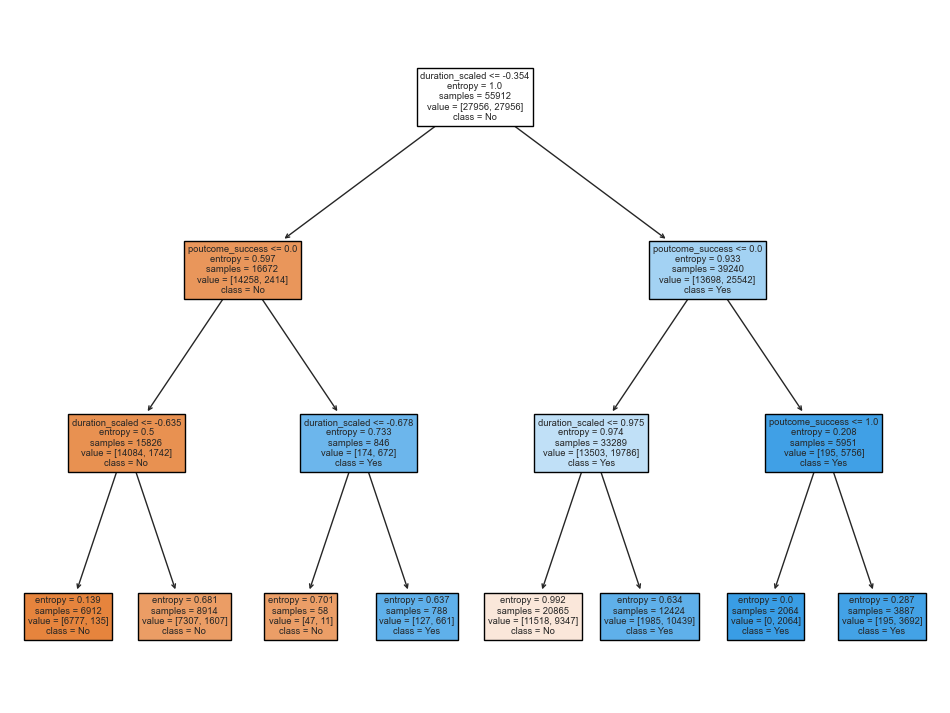

In [149]:
#plot the decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 9))
plot_tree(tree_model, feature_names=x_train_processed.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

- **Previous** success is critical: One of the first splits often involves whether the outcome of a previous campaign was a success ‚Äî those with past success are far more likely to convert.

- **Call duration** is a decisive factor: Longer call durations appear deep in the tree and are associated with much higher subscription likelihood.

- **Clients with no prior contact history** are more uncertain: The tree tends to predict "no" for those not previously contacted, unless other strong indicators exist (e.g., high call duration or contact in high-conversion months).

**Time-Based Insights**


- Next is to analyze how month, day_of_week, poutcome, and duration affect conversion

In [150]:
#a tabular visualization of the month  to subscription rates
pd.crosstab(df['month'], df['y'], normalize='index') * 100

y             no        yes
month                      
jan    89.878831  10.121169
feb    83.352208  16.647792
mar    48.008386  51.991614
apr    80.320600  19.679400
may    93.280546   6.719454
jun    89.777195  10.222805
jul    90.906454   9.093546
aug    88.986714  11.013286
sep    53.540587  46.459413
oct    56.233062  43.766938
nov    89.848866  10.151134
dec    53.271028  46.728972

- March, September, October, and December stand out with significantly higher subscription rates (close to or above 45%). These months are ideal for campaign launches.  

- May has the lowest success rate (only 6.72% subscribed), despite being a high-contact month. Suggestion on reducing calls during May or adjusting the strategy used in that month.  

- Other months like January, June, July, and November have relatively low subscription success rates (~10%), indicating lower efficiency.  


In [151]:
#a tabular visualization of the day_of_week  to subscription rates
pd.crosstab(df['day_of_week'], df['y'], normalize='index') * 100

y                   no        yes
day_of_week                      
Monday       87.604218  12.395782
Tuesday      88.060708  11.939292
Wednesday    88.170231  11.829769
Thursday     91.095178   8.904822
Friday       94.401187   5.598813
Saturday     58.540925  41.459075
Sunday       80.610236  19.389764

- **Saturday** has the highest subscription rate **(41.46%)**, far outperforming all other days. Consider prioritizing outbound calls or campaigns on Saturdays.  

- **Sunday** also performs relatively well **(19.39%)**, better than most weekdays. May be an underutilized day with good potential.  

- **Friday** has the lowest conversion rate **(5.60%)**, suggesting campaigns on this day are least effective. Reduce or avoid calling on Fridays.

- Weekdays **(Mon‚ÄìThu)** hover around **11‚Äì12%** success, showing similar, moderate effectiveness.

In [152]:
#a tabular visualization of the previous outcome  to subscription rates
pd.crosstab(df['poutcome'], df['y'], normalize='index') * 100

y                no        yes
poutcome                      
failure   87.390329  12.609671
other     83.315217  16.684783
success   35.274653  64.725347
unknown   90.838497   9.161503

- **Success**: Clients with a successful outcome in a previous campaign have the highest subscription rate, with **64.73%** saying "yes". This group should be **highly prioritized** in future marketing efforts due to their strong positive response.
  
- **Other**: The "other" group has a **16.68%** subscription rate, which is moderate. These clients show some potential and could be targeted after the "success" group.

- **Failure**: Clients who previously had a failed outcome show a **12.61%** success rate. This indicates lower effectiveness, and they may require a **different strategy or message**.

- **Unknown**: The "unknown" group has the lowest success rate after failure, with only **9.16%** subscribing. These clients may be **least responsive**, and targeting them should be **re-evaluated** to optimize campaign costs.


In [153]:
bins = [0, 100, 300, 600, 1200, df['duration'].max()] #group the call duration ranges for easier visualization
labels = ['Very Short (0-100s)', 'Short (100-300s)', 'Medium (300-600s)', 'Long (600-1200s)', 'Very Long (1200s+)'] #labels of the bins
df['duration_group'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False) #to create custom duration ranges

#a tabular visualization of the outcome in percentage
pd.crosstab(df['duration_group'], df['y'], normalize='index') * 100

y                           no        yes
duration_group                           
Very Short (0-100s)  98.946289   1.053711
Short (100-300s)     92.287210   7.712790
Medium (300-600s)    80.884250  19.115750
Long (600-1200s)     53.998148  46.001852
Very Long (1200s+)   38.256228  61.743772

- **Very Long (1200s+)**: These calls have the highest subscription rate, with **61.74%** of clients subscribing. This indicates that **longer conversations are strongly associated with client conversions**, highlighting the importance of maintaining engagement.

- **Long (600‚Äì1200s)**: With a **46.00%** subscription rate, these calls also show a strong potential for success. Sales agents should aim to **extend calls beyond 600 seconds** when feasible.

- **Medium (300‚Äì600s)**: A moderate success rate of **19.12%** suggests some impact, though not as strong. These calls could be **optimized with better targeting or scripting**.

- **Short (100‚Äì300s)** and **Very Short (0‚Äì100s)**: Subscription rates drop significantly to **7.71%** and **1.05%**, respectively. These brief interactions are largely ineffective, suggesting that **short calls should be minimized or followed up with longer engagements**.


**visualize the ROC Curve**

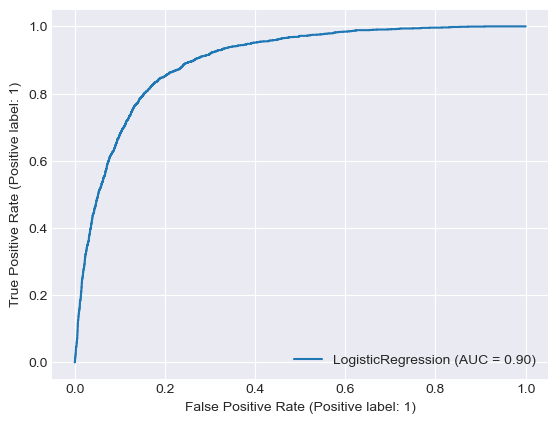

In [154]:
#visualize the ROC Curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, x_test_processed, y_test)
plt.show()


- The closer the curve hugs the top-left corner, the better the model is at correctly identifying yes vs. no responses.

- The model hugs the y-axis on thetop-left curve signifying it has high rates of correctly predicting the 'yes'/'no' outcomes of classification.

## 2. How can we use model predictions to prioritize clients and reduce unnecessary marketing efforts?

- Next we check the probabilities and use them to rank the clients.

In [155]:
y_probs = model.predict_proba(x_test_processed)[:, 1] #get probabilities only of the subscribers
#Add probabilities to the test set and rank clients. 
# create a dataframe with actual outcomes and predicted probabilities
ranking_df = x_test_processed.copy()
ranking_df['Actual'] = y_test
ranking_df['Subscription_Prob'] = y_probs

#rank clients by likelihood of subscribing in descending  order
ranking_df_sorted = ranking_df.sort_values(by='Subscription_Prob', ascending=False)
ranking_df_sorted.head(10) #get the first 10

previous  was_previously_contacted  loan_lencoded  default_lencoded  \
2386          0                         0              0                 0   
12347         0                         0              1                 0   
11635         0                         0              0                 0   
10989         0                         0              0                 0   
43901         0                         0              0                 0   
41588         2                         1              0                 0   
42265         3                         1              0                 0   
1731          0                         0              0                 0   
29342         0                         0              1                 0   
41785         2                         1              0                 0   

       housing_lencoded  age_scaled  balance_scaled  duration_scaled  \
2386                  1    0.381715       -0.434014        12.009558   
12347                 0   -1.217256       -0.458537        11.302529   
11635                 0    1.510400       -0.191138         9.185307   
10989                 0    1.792571        0.652713         9.131217   
43901                 0    0.852000       -0.455514         8.234875   
41588                 0   -0.088571       -0.021830         5.580619   
42265                 0    2.074742        1.261079         7.442848   
1731                  1    0.005486       -0.319799         8.516913   
29342                 1   -0.182628       -0.258660         7.721023   
41785                 0    0.193601       -0.057103         5.082222   

       campaign_scaled  day_scaled  ...  day_of_week_Saturday  \
2386          0.072215   -0.339973  ...                   0.0   
12347        -0.244847    1.221951  ...                   0.0   
11635         0.072215    0.380915  ...                   0.0   
10989         0.072215    0.140619  ...                   0.0   
43901        -0.561910   -0.700417  ...                   0.0   
41588         0.072215    0.020471  ...                   0.0   
42265        -0.244847   -0.339973  ...                   0.0   
1731         -0.561910   -0.820565  ...                   0.0   
29342        -0.244847   -1.661601  ...                   0.0   
41785        -0.244847   -0.339973  ...                   0.0   

       day_of_week_Sunday  day_of_week_Thursday  day_of_week_Tuesday  \
2386                  0.0                   0.0                  1.0   
12347                 0.0                   1.0                  0.0   
11635                 0.0                   1.0                  0.0   
10989                 0.0                   0.0                  1.0   
43901                 0.0                   0.0                  1.0   
41588                 0.0                   0.0                  1.0   
42265                 0.0                   1.0                  0.0   
1731                  0.0                   0.0                  0.0   
29342                 1.0                   0.0                  0.0   
41785                 0.0                   0.0                  0.0   

       day_of_week_Wednesday  poutcome_other  poutcome_success  \
2386                     0.0             0.0               0.0   
12347                    0.0             0.0               0.0   
11635                    0.0             0.0               0.0   
10989                    0.0             0.0               0.0   
43901                    0.0             0.0               0.0   
41588                    0.0             0.0               1.0   
42265                    0.0             0.0               0.0   
1731                     0.0             0.0               0.0   
29342                    0.0             0.0               0.0   
41785                    0.0             0.0               0.0   

       poutcome_unknown  Actual  Subscription_Prob  
2386                1.0       0           1.000000  
12347        

**Tune Threshold Using Precision-Recall Curve.**

In [156]:
from sklearn.metrics import precision_recall_curve #using Precision-Recall Curve and F1 score to find the best threshold

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1 = 2 * (precision * recall) / (precision + recall)
f1 = np.nan_to_num(f1, nan=0.0) #to safely handle zero-division(replace Nans with zero)
best_thresh = thresholds[np.argmax(f1)] #looking for best threshold for maximum F1score
print(f"Best threshold (by F1): {best_thresh:.2f}")

Best threshold (by F1): 0.66


C:\Users\User\AppData\Local\Temp\ipykernel_4160\3919652362.py:4: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


- The error occurs when precision and recall are zero at the same time.

- The best threshold is at 0.66. This indicates clients with probability ‚â• 0.66 are the best to target ‚Äî balancing fewer calls with better results.
- Though because the data is skewed we adjust the threshold to 0.4 to increase the allowance of the calls.

In [157]:
threshold_m = 0.4 
target_clients = ranking_df_sorted[ranking_df_sorted['Subscription_Prob'] >=threshold_m] 
#The clients that are above and equal to the thresholdprobability
print(f"Number of clients to contact: {len(target_clients)}")
print(f"Reduction in marketing calls: {100 - (len(target_clients) / len(x_test_processed) * 100):.1f}%")

Number of clients to contact: 3663
Reduction in marketing calls: 73.0%


- **Number of Clients to Contact:** 3,663  
  Based on the model's predictions, only 3,663 clients need to be contacted to achieve optimal results. This allows the marketing team to focus efforts on a more targeted and promising group.

- **Reduction in Marketing Calls:** 73.0%  
  By using the model, the number of marketing calls is reduced by 73%. This represents a significant cost-saving and efficiency improvement, minimizing unnecessary outreach while maximizing the likelihood of positive responses.


In [158]:
# Actual subscribers captured
actual_subscribers = target_clients['Actual'].sum() #sum of actual subs
total_subscribers = y_test.sum() #total subs

conversion_retention_rate = actual_subscribers / total_subscribers * 100 #number of accurate predictions.
print(f"Subscribers retained: {conversion_retention_rate:.1f}%")


Subscribers retained: 84.8%


- **Subscribers Retained:** 84.8%  
  The model successfully retains 84.8% of potential subscribers within the reduced contact group. This demonstrates high effectiveness in identifying and targeting the right clients, ensuring minimal loss in conversion while significantly reducing outreach.


## 3. Can we accurately predict which customers are likely to subscribe to a term deposit based on their profile?

- We start by model evaluation.

**Logistic Model evaluation**

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
#evaluating the accuracy of the Logistic model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))

Accuracy: 0.8460631082276615
Precision: 0.41833333333333333
Recall: 0.7853566958698373
F1 Score: 0.5458895171813832
ROC AUC: 0.8973024215251514


- **Accuracy:** 84.6%  
  The model correctly predicts the outcome in approximately 84.6% of the cases.

- **Precision:** 41.8%  
  Of all clients predicted to subscribe, only 41.8% actually did. This indicates a moderate rate of false positives.

- **Recall (Sensitivity):** 78.5%  
  The model successfully identifies 78.5% of actual subscribers, which shows strong performance in capturing true positives.

- **F1 Score:** 0.546  
  The F1 score balances precision and recall. A score of 0.546 reflects the trade-off between the two, favoring recall in this case.

- **ROC AUC:** 0.897  
  The model shows excellent overall classification ability. A ROC AUC of 0.897 suggests the model effectively distinguishes between subscribers and non-subscribers.

The logistic model performs well in identifying potential subscribers (high recall and ROC AUC), though precision is lower. This makes it suitable for use cases where it's more important to capture as many subscribers as possible, even if it means contacting some non-subscribers.


**Plot the ROC Curve using the Logistic Model**

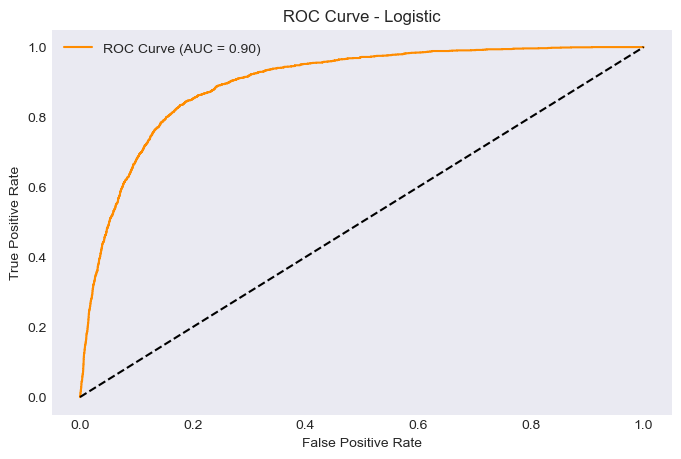

In [160]:
fpr, tpr, _ = roc_curve(y_test, y_probs) #first get the False positive rate and True positive rate

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_probs)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic')
plt.legend()
plt.grid()
plt.show()

- AUC Score: ~0.90

* This is a very strong model.

* It means the model can correctly distinguish between a ‚Äúyes‚Äù and ‚Äúno‚Äù response about 90% of the time.

In practice, this means marketing can confidently rank and prioritize customers based on their likelihood to subscribe.  

**summary**
- The logistic model is excellent at identifying customers who are likely to say yes ‚Äî ideal for reducing wasted outreach and focusing efforts on the right audience.

**Cross-Validated ROC/AUC**

In [161]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, x_test_processed, y_test, cv=cv, scoring='roc_auc')
print("CV ROC AUC:", cv_scores.mean())

CV ROC AUC: 0.901767972887279


- **Cross-Validated ROC AUC:** 0.902  
  The average ROC AUC across cross-validation folds is 0.902, which confirms the model's strong and consistent ability to distinguish between subscribers and non-subscribers across different subsets of the data.

The high cross-validated ROC AUC indicates that the model generalizes well and is not overfitting to a specific training set. This strengthens confidence in deploying the logistic model for real-world prediction.


**DecisionTree Classifier Model**

In [162]:
# Probabilities for ROC/AUC using  decision tree model
y_proba = tree_model.predict_proba(x_test_processed)[:, 1]


print("Accuracy tree:", accuracy_score(y_test, y_pred_tree))
print("Precision tree:", precision_score(y_test, y_pred_tree))
print("Recall tree:", recall_score(y_test, y_pred_tree))
print("F1 Score tree:", f1_score(y_test, y_pred_tree))
print("ROC AUC tree:", roc_auc_score(y_test, y_proba))


Accuracy tree: 0.8715718077263345
Precision tree: 0.4636363636363636
Recall tree: 0.574468085106383
F1 Score tree: 0.5131358300726663
ROC AUC tree: 0.8219955236122707


- **Accuracy:** 87.2%  
  The model correctly classifies 87.2% of the observations, slightly outperforming the logistic regression model in overall accuracy.

- **Precision:** 46.4%  
  Among clients predicted to subscribe, 46.4% actually did. This shows a slight improvement in precision over the logistic model, meaning fewer false positives.

- **Recall (Sensitivity):** 57.4%  
  The model identifies 57.4% of actual subscribers. This is notably lower than the logistic model's recall, indicating more missed positive cases.

- **F1 Score:** 0.513  
  The F1 score reflects the balance between precision and recall. While lower than logistic regression, it shows the model performs moderately well on both aspects.
  
- **ROC AUC:** 0.822  
  The model's ability to separate subscribers from non-subscribers is good, though not as strong as the logistic regression model (ROC AUC of 0.897).

The Decision Tree model achieves higher accuracy and precision, making it more conservative by reducing false positives. However, it sacrifices recall, missing more actual subscribers. This model may be preferred in scenarios where it's more important to avoid unnecessary marketing calls than to capture every potential subscriber.


**Plot the ROC Curve using the DecisionTree Model**

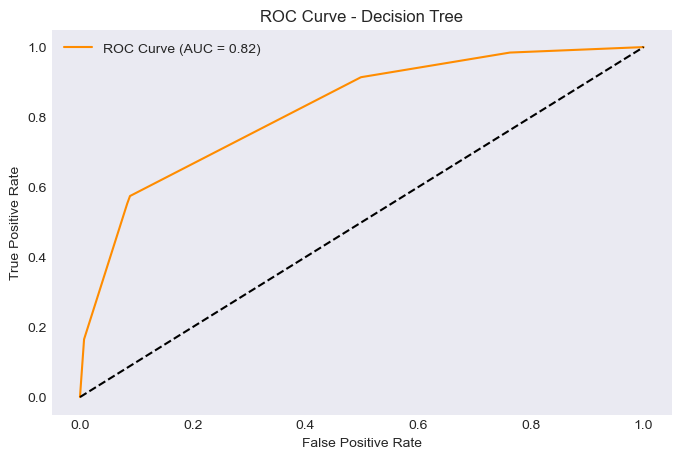

In [163]:
#plotting the ROC/AUC for decision tree model
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.grid()
plt.show()

-  Score: ~0.82

- This is still a good model, though not as strong as logistic regression.

- It‚Äôs simpler and easier to visualize, which can help with transparency and rule-based decisions.  

**summary**
- The tree model performs well but slightly less accurately. However, it‚Äôs easier to explain and could be used to build rules or automated systems for campaign targeting.

**Using the odds-ratios from statsmodel to visualize the features with the highest likelihood of subscribing**

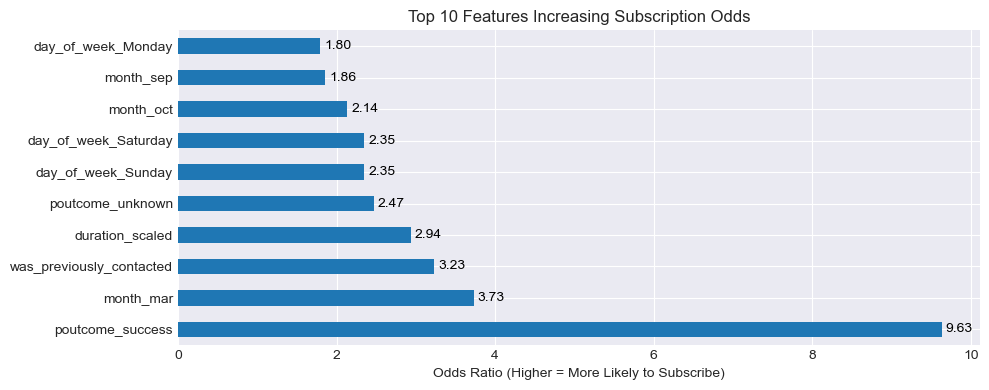

In [164]:
# Get top 10 positive predictors
top_10_positive = odds_ratios[odds_ratios > 1].sort_values(ascending=False).head(10)

# Plot with annotations
ax = top_10_positive.plot(kind='barh', figsize=(10,4), 
                         title='Top 10 Features Increasing Subscription Odds')
plt.xlabel('Odds Ratio (Higher = More Likely to Subscribe)')

# Add value labels
for i, v in enumerate(top_10_positive):
    ax.text(v + 0.05, i, f"{v:.2f}", color='black', va='center')

plt.tight_layout()
plt.show()

- These are the most influential features with odds ratios significantly greater than 1:

    * Outcome of Previous Campaign ‚Äì Success: Customers who previously said "yes" are 9.6 times more likely to subscribe again.

    * Contact Month ‚Äì March, October, September: Customers contacted in these months are 2‚Äì3.7 times more likely to convert.

    * Previous Contact History: Clients who were previously contacted are over 3 times more likely to subscribe.

    * Longer Call Duration: Each increase in standardized call duration is associated with almost 3 times higher odds of subscription.

    * Weekend Contact: Calls on Saturdays or Sundays increase conversion odds by 2.3 times.

- Factors That Decrease Likelihood:
(Not shown here but typically includes months like May, short duration, or no prior contact history)

**Tree Feature Importance** 

In [165]:
tree_importance_df = pd.DataFrame({
    'Feature': x_train_processed.columns,
    'Importance': tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

tree_importance_df.head()


Feature  Importance
7    duration_scaled    0.759351
43  poutcome_success    0.240649
0           previous    0.000000
33         month_nov    0.000000
25         month_aug    0.000000

- **`duration`** is by far the most influential feature, contributing about **76%** to the decision-making process. This aligns with expectations, as call duration is a strong indicator of subscription.
- **`poutcome`** also plays a significant role (24%), indicating that a successful previous campaign outcome greatly increases the likelihood of subscription. 

Focus future model improvements and business strategies on the top two features

## Conclusions 


**1. Prior Engagement and Call Duration Are Powerful Predictors of Success**
- The model revealed that clients who had been contacted before and those who engage in longer conversations are substantially more likely to subscribe. These two factors alone   
  significantly improve the odds of a positive outcome. 
 
**2. Campaign Timing Greatly Affects Subscription Rates** 
- Subscription success is not evenly distributed across months or days. March, September, October, and weekends show considerably higher conversion rates, indicating that when a  
  client is contacted matters almost as much as who is contacted.
  
**3. The Classification Model Can Enhance Targeting and Reduce Waste**
- With an ROC AUC of ~0.90, the logistic regression model is highly capable of distinguishing likely subscribers from non-subscribers, offering a valuable tool to improve campaign  
  efficiency by reducing unnecessary contacts and focusing on high-probability leads.




## Recommendations 

**1. Prioritize Follow-ups with Previously Contacted Clients**
- Clients who were previously contacted are over 3 times more likely to subscribe to a term deposit. This suggests familiarity or prior interest increases success.  
  Focus campaign efforts on individuals with a contact history ‚Äî even if they previously said "no" ‚Äî and tailor messaging to build on prior interactions. 

**2. Align Campaign Timing with High-Performing Months**
- Conversions are significantly higher in March, September, October, and December, with March showing the highest subscription rate (52%).  
  Concentrate outreach and budget allocation during these high-performing months, and reduce or avoid campaigns during low-performing ones like May and July.

**3. Use Call Duration as a Real-Time Quality Signal**
- Call duration strongly correlates with positive outcomes. For example, calls lasting over 600 seconds have nearly 50‚Äì60% success rates, while ultra-short calls almost never convert.  
  Monitor call duration as a live KPI. If a call crosses a certain threshold (e.g., 300 seconds), escalate for deeper engagement or prioritize for follow-up.


  



  

                                     **The endüòé**